In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir /content/ds
!cp /content/drive/MyDrive/bd_traffic_sign_dataset.zip /content/ds
!unzip /content/drive/MyDrive/bd_traffic_sign_dataset.zip -d /content/ds

Streaming output truncated to the last 5000 lines.
  inflating: /content/ds/Pedestrian crossing/crossing120.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1201.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1202.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1203.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1205.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1207.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1209.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing121.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1211.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1212.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1216.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing122.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1222.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing1226.jpg  
  inflating: /content/ds/Pedestrian crossing/crossing123

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.12.0


In [ ]:
dataset = '/content/ds'

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
no_classes = 13

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='training',
                                                                 seed=66)
validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='validation',
                                                                 seed=66)
#test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
#                                                                 shuffle=True,
#                                                                 batch_size=BATCH_SIZE,
 #                                                                image_size=IMG_SIZE)

Found 8386 files belonging to 13 classes.
Using 6709 files for training.
Found 8386 files belonging to 13 classes.
Using 1677 files for validation.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

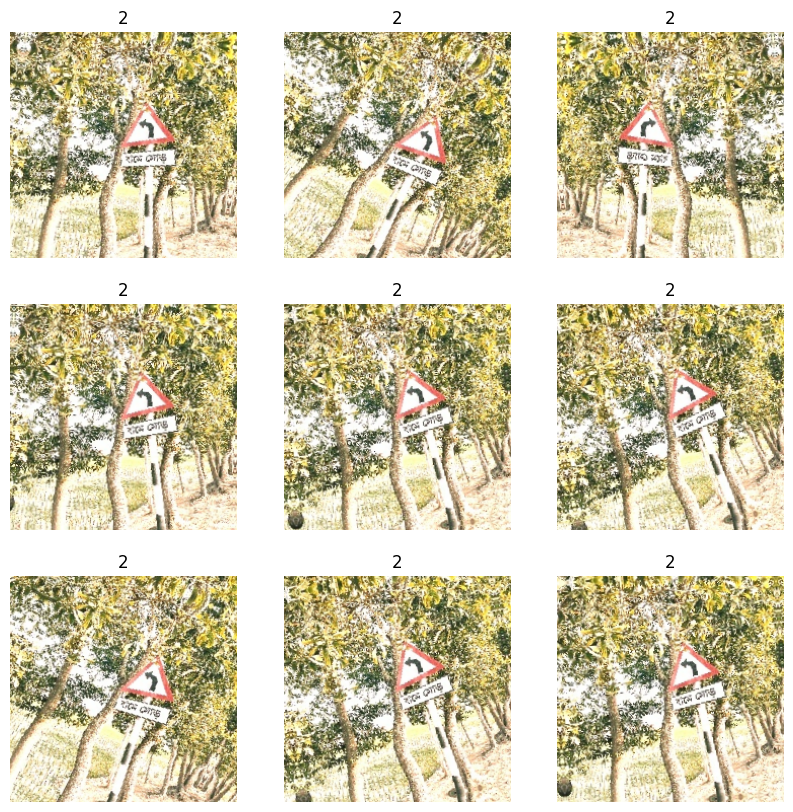

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.NASNetLarge(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


343610240/343610240 [==============================] - 4s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "NASNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv1 (Conv2D)            (None, 111, 111, 96  2592        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn1 (BatchNormalization)  (None, 111, 111, 96  384         ['stem_conv1[0][0]']             
                                )                                                            

In [ ]:
nb_classes = 13
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)

outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

modelF = model

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_average_pooling2d (G  (None, 4032)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 4032)              0         
                                                             

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy']) 

In [ ]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
210/210 [==============================] - 138s 494ms/step - loss: 0.9315 - accuracy: 0.7050 - val_loss: 0.6130 - val_accuracy: 0.7961
Epoch 2/100
210/210 [==============================] - 101s 479ms/step - loss: 0.4750 - accuracy: 0.8454 - val_loss: 0.4731 - val_accuracy: 0.8533
Epoch 3/100
210/210 [==============================] - 102s 484ms/step - loss: 0.3798 - accuracy: 0.8770 - val_loss: 0.4612 - val_accuracy: 0.8366
Epoch 4/100
210/210 [==============================] - 102s 483ms/step - loss: 0.2956 - accuracy: 0.9025 - val_loss: 0.2719 - val_accuracy: 0.9117
Epoch 5/100
210/210 [==============================] - 102s 483ms/step - loss: 0.2665 - accuracy: 0.9119 - val_loss: 0.2423 - val_accuracy: 0.9135
Epoch 6/100
210/210 [==============================] - 102s 484ms/step - loss: 0.2452 - accuracy: 0.9214 - val_loss: 0.2893 - val_accuracy: 0.9016
Epoch 7/100
210/210 [==============================] - 101s 481ms/step - loss: 0.2336 - accuracy: 0.9235 - val_loss: 0

In [ ]:
#scores = model.evaluate(test_dataset)

In [ ]:
modelF.trainable = True
modelF.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_average_pooling2d (G  (None, 4032)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 4032)              0         
                                                             

In [ ]:
modelF.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

In [ ]:
epochs = 100
modelF.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
210/210 [==============================] - 548s 2s/step - loss: 0.0569 - accuracy: 0.9820 - val_loss: 0.0388 - val_accuracy: 0.9863
Epoch 2/100
210/210 [==============================] - 332s 2s/step - loss: 0.0236 - accuracy: 0.9911 - val_loss: 0.0299 - val_accuracy: 0.9928
Epoch 3/100
210/210 [==============================] - 331s 2s/step - loss: 0.0218 - accuracy: 0.9937 - val_loss: 0.0188 - val_accuracy: 0.9922
Epoch 4/100
210/210 [==============================] - 332s 2s/step - loss: 0.0155 - accuracy: 0.9954 - val_loss: 0.0133 - val_accuracy: 0.9934
Epoch 5/100
210/210 [==============================] - 332s 2s/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.0219 - val_accuracy: 0.9917
Epoch 6/100
210/210 [==============================] - 332s 2s/step - loss: 0.0111 - accuracy: 0.9966 - val_loss: 0.0070 - val_accuracy: 0.9970
Epoch 7/100
210/210 [==============================] - 331s 2s/step - loss: 0.0075 - accuracy: 0.9978 - val_loss: 0.0099 - val_accuracy:

In [ ]:
#scores = modelF.evaluate(test_dataset)

In [ ]:
class_names = validation_dataset.class_names
class_names

['College in front',
 'Crossroad',
 'Left turn',
 'Market in front',
 'Mosque in front',
 'Pedestrian crossing',
 'Rail crossing',
 'Right turn',
 'School in front',
 'Side road left',
 'Side road right',
 'Speed breaker',
 'Speed limit']

first image to predict
actual label: Speed limit
1/1 [==============================] - 6s 6s/step
predicted label: Speed limit


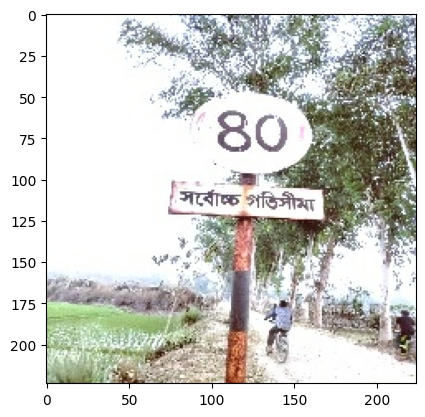

In [ ]:
import numpy as np
for images_batch, labels_batch in validation_dataset.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = modelF.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = modelF.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 46ms/step


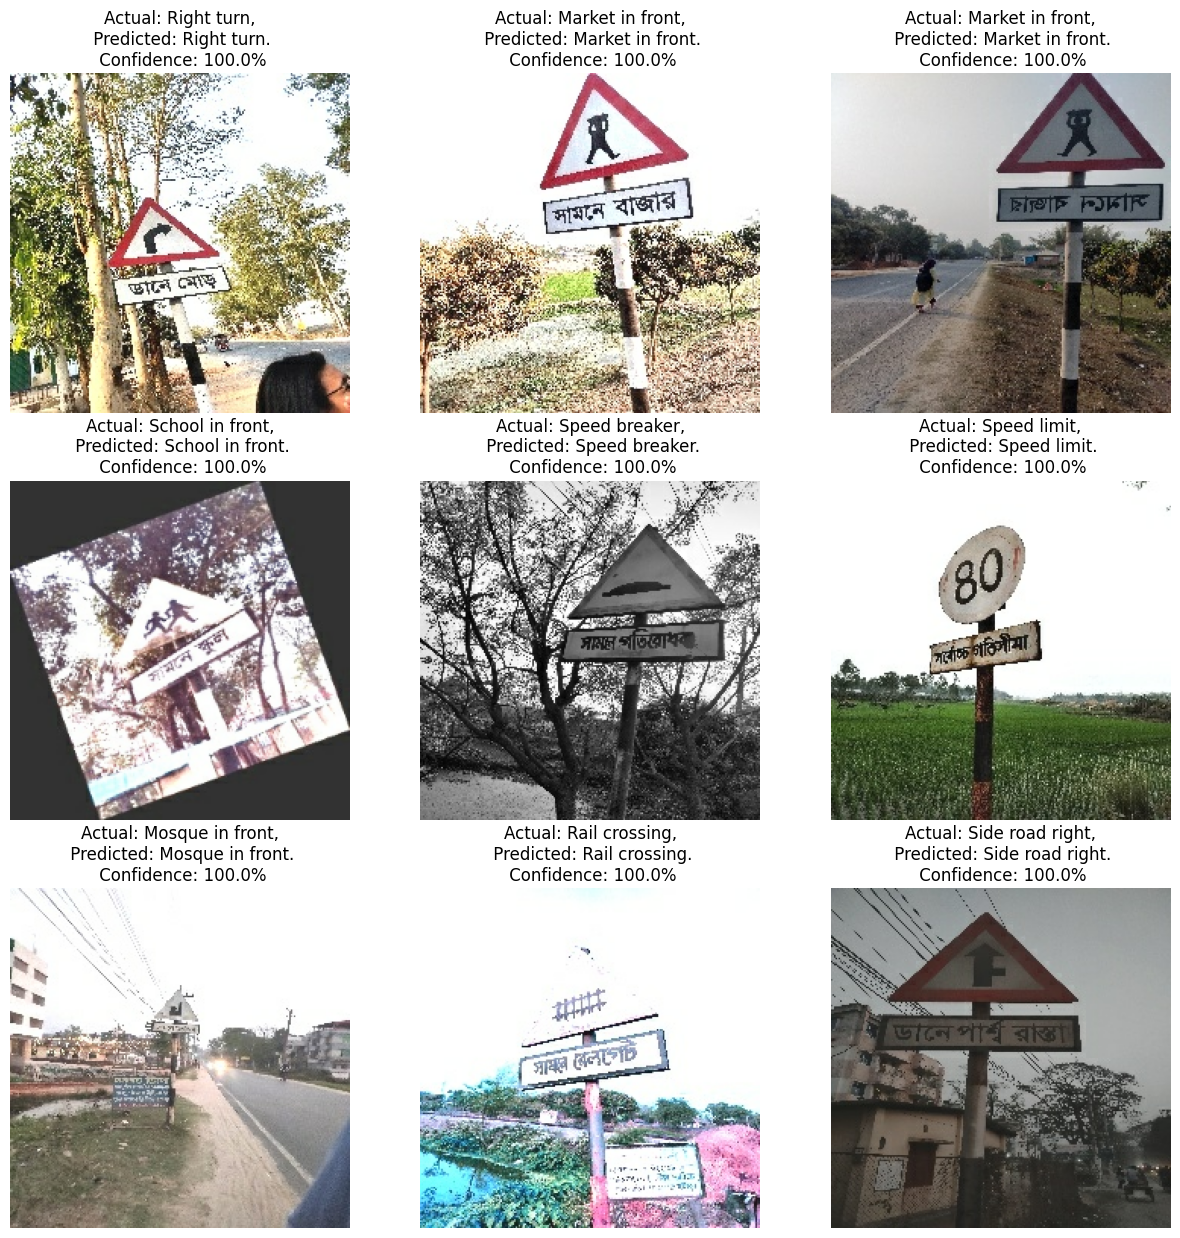

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(modelF, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='test.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('test.zip')
f.keys()
!unzip test.zip

In [ ]:
image_to_predict = [
    "/content/test/IMG20230228181526.jpg", 
    "/content/test/IMG20230228181936.jpg",
    "/content/test/IMG20230228181937.jpg",
    "/content/test/IMG_20230228_153940.jpg",
   "/content/test/IMG_20230228_154105 (2).jpg",
    "/content/test/IMG_20230228_154121 (2).jpg",
    "/content/test/IMG_20230228_154132.jpg",
    "/content/test/IMG_20230228_154413.jpg",
    "/content/test/IMG_20230228_154501.jpg",
    "/content/test/IMG_20230228_154502.jpg",
    "/content/test/IMG_20230228_155113.jpg",
    "/content/test/IMG_20230228_155545.jpg",
    "/content/test/IMG_20230228_155547.jpg",
    "/content/test/IMG_20230228_155640.jpg",
    "/content/test/IMG_20230228_155710.jpg",
    "/content/test/IMG_20230228_155716.jpg",
    "/content/test/IMG_20230228_160628.jpg",
    "/content/test/IMG_20230228_161901.jpg",
    "/content/test/IMG_20230228_162133.jpg",
    "/content/test/IMG_20230228_162218.jpg",
    "/content/test/IMG_20230228_162229 (2).jpg",
    "/content/test/IMG_20230228_162333.jpg",
    "/content/test/IMG_20230228_163326.jpg",
    "/content/test/IMG_20230228_163406.jpg",
    "/content/test/IMG_20230228_163739.jpg",
    "/content/test/IMG_20230228_163741.jpg",
    "/content/test/IMG_20230228_163827 (2).jpg",
    "/content/test/IMG_20230228_175945.jpg",
    "/content/test/IMG_20230228_180036.jpg",
    "/content/test/IMG_20230228_180050 (2).jpg",
    "/content/test/IMG_20230228_181559.jpg",
    "/content/test/IMG_20230228_181807.jpg",
    "/content/test/IMG_20230228_182024.jpg",
    "/content/test/IMG_20230228_182147.jpg",
    "/content/test/IMG_20230228_182211.jpg",
    "/content/test/IMG_20230228_182239.jpg",
    "/content/test/IMG_20230228_182339.jpg",
    "/content/test/IMG_20230228_182340.jpg",
    "/content/test/IMG_20230228_155100.jpg",
    "/content/test/IMG_20230228_155102.jpg"

  

    ]
for imgi in image_to_predict:
  img = keras.utils.load_img(imgi, target_size=(224,224))
  ix = keras.utils.img_to_array(img)
  ix = np.expand_dims(ix, axis=0)
  prediction = modelF.predict(ix)
  cls = tf.argmax(prediction[0], axis=-1)
  print(prediction, cls)
  print(f'{class_names[cls]} --> {imgi}')

In [ ]:
'''
IMG_20230228_153940 = crossroad (+1)
IMG_20230228_154501 = crossroad (+1)
IMG_20230228_154502 = crossroad (+1)

IMG_20230228_154105 (2) = market in front (+1)
IMG_20230228_154121 (2)= market in front (+1)
IMG_20230228_154132 = market in front (+1)

IMG_20230228_154413 = Left turn (+1)
IMG_20230228_155545 = Left turn (+1)
IMG_20230228_155547 = Left turn (+1)
IMG_20230228_160628 = Left turn (+1)

IMG_20230228_155100 = Right turn (+1)
IMG_20230228_155102 = Right turn (+1)
IMG_20230228_155113  = Right turn (+1)

IMG_20230228_155640 = Pedestrian crossing (+1)
IMG_20230228_155710 = Pedestrian crossing (+1)
IMG_20230228_155716 = Pedestrian crossing (+1)

IMG_20230228_161901 = Speed breaker (+1)
IMG_20230228_162218 =  Speed breaker (+1)
IMG_20230228_162229 (2) =  Speed breaker (+1)

IMG_20230228_163326  = Rail crossing (+1)
IMG_20230228_163406 = Rail crossing (+1)
IMG_20230228_162133 = Rail crossing (+1)

IMG_20230228_163739 = college in front (+1)
IMG_20230228_163741 = college in front (+1)
IMG_20230228_163827 (2) = college in front (+1)

IMG_20230228_175945 = speed limit (+1)
IMG_20230228_180036 = speed limit (+1)
IMG_20230228_180050 (2) = speed limit (+1)

IMG_20230228_181559 = Mosque in front (+1)
IMG_20230228_181807 = Mosque in front (+1)
IMG20230228181526 = Mosque in front (+1)

IMG_20230228_182147 = school in front (+1)
IMG_20230228_182211 = school in front (+1)
IMG_20230228_182239 = school in front (+1)

IMG_20230228_182339 = Side road leftt (+1)
IMG_20230228_182340 = = Side road leftt (+1)
IMG_20230228_162333 = Side road left (+1)

IMG_20230228_182024 = Side road right (+1)
IMG20230228181936 = Side road right (+1)
IMG20230228181937 = Side road right (+1)

hit = ? miss = ?
acc = ?
'''